In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_curve,
    auc,
)
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

In [2]:
# Load and preprocess data
def Normalize(X):
    X_mean = np.mean(X, axis=0)
    X_std = np.std(X, axis=0)
    X_standardize = (X-X_mean)/X_std
    return X_standardize                       # TODO: Implement the normalization function

def load_data():
    # url_hospital = "https://archive.ics.uci.edu/ml/machine-learning-databases/haberman/haberman.data"
    data = pd.read_csv(
        "haberman.csv",
        header=None,
        names=["age", "year", "nodes_detected", "survival_status"],
    )
    X = data.iloc[:, :3].to_numpy()
    y = (data.iloc[:, 3] == 1).astype(int)  # Convert survival status to binary
    X = Normalize(X)
    
    return X, y

Data Summary
              age        year  nodes_detected  survival_status
count  306.000000  306.000000      306.000000       306.000000
mean    52.457516   62.852941        4.026144         1.264706
std     10.803452    3.249405        7.189654         0.441899
min     30.000000   58.000000        0.000000         1.000000
25%     44.000000   60.000000        0.000000         1.000000
50%     52.000000   63.000000        1.000000         1.000000
75%     60.750000   65.750000        4.000000         2.000000
max     83.000000   69.000000       52.000000         2.000000

Number of null values in the data
age                0
year               0
nodes_detected     0
survival_status    0
dtype: int64


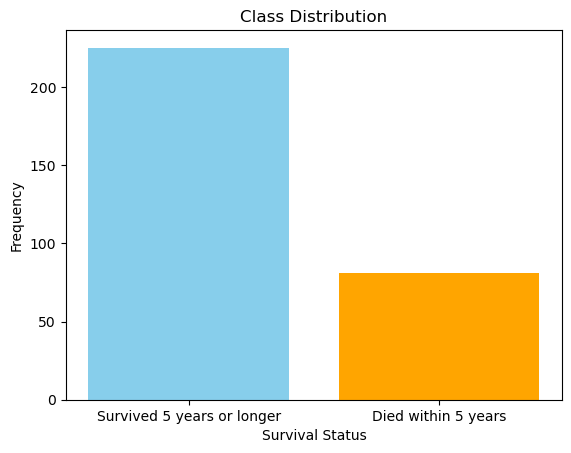

In [3]:
# Explore the Data
data = pd.read_csv(
        "haberman.csv",
        header=None,
        names=["age", "year", "nodes_detected", "survival_status"],
    )

print(r"Data Summary")
print(f"{data.describe()}\n")
print("Number of null values in the data")
print(data.isnull().sum())

plt.bar(data['survival_status'].value_counts().index, data['survival_status'].value_counts().values, color=['skyblue', 'orange'])

plt.title("Class Distribution")
plt.xlabel("Survival Status")
plt.ylabel("Frequency")
plt.xticks(ticks=[1, 2], labels=["Survived 5 years or longer", "Died within 5 years"]) 
plt.savefig('Class_Distribution.png')
plt.show()

In [4]:
# Logistic function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))                      # TODO: Implement the sigmoid function

# Negative Log-Likelihood
def nll(beta, X, y):
    z = X @ beta
    g_x = sigmoid(z)
    nll = -y.T @ np.log(g_x) - (1-y).T @ np.log(1-g_x)
    return nll                # TODO: Implement NLL function

# Gradient of NLL
def gradient(beta, X, y):
    N = X.shape[0]
    z = X @ beta
    g_x = sigmoid(z)
    return X.T @ (g_x - y)    # TODO: Implement the gradient of NLL

# Hessian of NLL
def hessian(beta, X):
    N = X.shape[0]
    z = X @ beta
    g_x = sigmoid(z)
    W = g_x * (1 - g_x)
    return (X.T*W) @ X  # TODO: Implement the hessian of NLL

In [6]:
def finite_difference(X, y, epsilon=1e-6):
    fd_method = np.zeros(3)
    for j in range(len(beta)):
        beta1 = np.zeros(X.shape[1])  
        beta2 = np.zeros(X.shape[1])  
        beta1[j] += epsilon
        beta2[j] -= epsilon
        fd_method[j] = (nll(beta1, X, y) - nll(beta2, X, y)) / (2 * epsilon)
    return fd_method
    
X,y = load_data()
beta = np.zeros(X.shape[1])  
grad = gradient(beta, X, y)  
fin_diff = finite_difference(X, y)

print("Our Gradient Implementation:", grad)
print("Finite Differences:", fin_diff)

Our Gradient Implementation: [ 9.17329379 -0.64370432 38.71362156]
Finite Differences: [ 9.17329379 -0.64370433 38.71362158]


In [7]:
def nll_regularization(beta, X, y, lamd):
    N = X.shape[0]
    z = X @ beta
    g_x = sigmoid(z)
    nll = -y.T @ np.log(g_x) - (1-y).T @ np.log(1-g_x) + (lamd/2)*beta.T@beta
    return nll                # TODO: Implement NLL function
    
# Gradient of NLL
def gradient_regularization(beta, X, y, lamd):
    N = X.shape[0]
    z = X @ beta
    g_x = sigmoid(z)
    return X.T @ (g_x - y) + lamd*beta    # TODO: Implement the gradient of NLL

# Hessian of NLL
def hessian_regularization(beta, X, lamd):
    N = X.shape[0]
    z = X @ beta
    g_x = sigmoid(z)
    W = g_x * (1 - g_x)
    return (X.T*W) @ X + lamd * np.eye(X.shape[1])  # TODO: Implement the hessian of NLL


In [8]:
# Newton-Raphson optimization
def newton_raphson(X, y, tol=1e-5, max_iter=1000):
    intercept = np.ones((X.shape[0], 1)) 
    X = np.hstack((intercept, X))
    beta = np.zeros(X.shape[1])     # TODO: Implement the Newton-Raphson optimization
    prev_loss = nll(beta, X, y)
    epsilon = 1e-6
    for i in range(max_iter):
        g = gradient(beta, X, y)
        H = hessian(beta, X)
        
        H += epsilon * np.eye(H.shape[0])
        H_inv = np.linalg.inv(H)
        beta -= H_inv @ g
        current_loss = nll(beta, X, y)
        if np.abs(prev_loss-current_loss) < tol:
            print(f"Converged in {i+1} iterations.")
            print(f"Loss after {i+1} iterations: {current_loss}")
            break
    return beta

# Newton-Raphson optimization
def newton_raphson_regularization(X, y, lamd, tol=1e-5, max_iter=1000):
    intercept = np.ones((X.shape[0], 1)) 
    X = np.hstack((intercept, X))
    beta = np.zeros(X.shape[1])     # TODO: Implement the Newton-Raphson optimization
    prev_loss = nll(beta, X, y)
    epsilon = 1e-6
    for i in range(max_iter):
        g = gradient_regularization(beta, X, y, lamd)
        H = hessian_regularization(beta, X, lamd)
        
        H += epsilon * np.eye(H.shape[0])
        H_inv = np.linalg.inv(H)
        beta -= H_inv @ g
        current_loss = nll(beta, X, y)
        if np.abs(prev_loss-current_loss) < tol:
            print(f"Converged in {i+1} iterations.")
            print(f"Loss after {i+1} iterations: {current_loss}")
            break
    return beta

In [9]:
def predict(X, beta):
    intercept = np.ones((X.shape[0], 1)) 
    X = np.hstack((intercept, X))
    z = X @ beta
    g_x = sigmoid(z)
    return np.where(g_x >  0.55, 1, 0)  # TODO: Implement the prediction function

In [10]:
# Main workflow

# Load and preprocess data
X, y = load_data()

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train logistic regression model
beta = newton_raphson(X_train, y_train)

# Predictions and evaluation metrics for Newton Raphson
NP_preds = predict(X_test, beta)
NP_accuracy = accuracy_score(y_test, NP_preds)
NP_precision = precision_score(y_test, NP_preds)
NP_recall = recall_score(y_test, NP_preds)
NP_f1 = f1_score(y_test, NP_preds)

# Print metrics
print(f"Newton Raphson Accuracy: {NP_accuracy:.2f}")
print(f"Newton Raphson Precision: {NP_precision:.2f}")
print(f"Newton Raphson Recall: {NP_recall:.2f}")
print(f"Newton Raphson F1 Score: {NP_f1:.2f}")
print(f"Intercept: {beta[0]}")
print(f"Beta Coeff: {beta[1:]}")

Newton Raphson Accuracy: 0.71
Newton Raphson Precision: 0.74
Newton Raphson Recall: 0.91
Newton Raphson F1 Score: 0.82
Intercept: 1.1389180717341307
Beta Coeff: [-0.35783559  0.13169748 -0.73797365]


In [11]:
# Train logistic regression model
beta_reg = newton_raphson_regularization(X_train, y_train, 10)

# Predictions and evaluation metrics for Newton Raphson
NP_preds = predict(X_test, beta_reg)
NP_accuracy = accuracy_score(y_test, NP_preds)
NP_precision = precision_score(y_test, NP_preds)
NP_recall = recall_score(y_test, NP_preds)
NP_f1 = f1_score(y_test, NP_preds)

# Print metrics
print(f"Newton Raphson L2-reg Accuracy: {NP_accuracy:.2f}")
print(f"Newton Raphson L2-reg Precision: {NP_precision:.2f}")
print(f"Newton Raphson L2-reg Recall: {NP_recall:.2f}")
print(f"Newton Raphson L2-reg F1 Score: {NP_f1:.2f}")
print(f"Intercept: {beta_reg[0]}")
print(f"Beta Coeff: {beta_reg[1:]}")

Newton Raphson L2-reg Accuracy: 0.71
Newton Raphson L2-reg Precision: 0.74
Newton Raphson L2-reg Recall: 0.91
Newton Raphson L2-reg F1 Score: 0.82
Intercept: 0.9089690606253708
Beta Coeff: [-0.24943194  0.08839307 -0.5595791 ]


In [12]:
# Train logistic regression model using sklearn
logreg = LogisticRegression(fit_intercept=True, solver="lbfgs")
logreg.fit(X_train, y_train)

# Predictions and evaluation metrics for Scikit Learn
SC_preds = logreg.predict(X_test)
SC_accuracy = accuracy_score(y_test, SC_preds)
SC_precision = precision_score(y_test, SC_preds)
SC_recall = recall_score(y_test, SC_preds)
SC_f1 = f1_score(y_test, SC_preds)
# Print metrics
print(f"Scikit Learn Accuracy: {SC_accuracy:.2f}")
print(f"Scikit Learn Precision: {SC_precision:.2f}")
print(f"Scikit Learn Recall: {SC_recall:.2f}")
print(f"Scikit Learn F1 Score: {SC_f1:.2f}")
print(f"Intercept: {logreg.intercept_}")
print(f"Beta Coeff: {logreg.coef_}")

Scikit Learn Accuracy: 0.69
Scikit Learn Precision: 0.73
Scikit Learn Recall: 0.91
Scikit Learn F1 Score: 0.81
Intercept: [1.13538518]
Beta Coeff: [[-0.34552654  0.12646286 -0.71527507]]


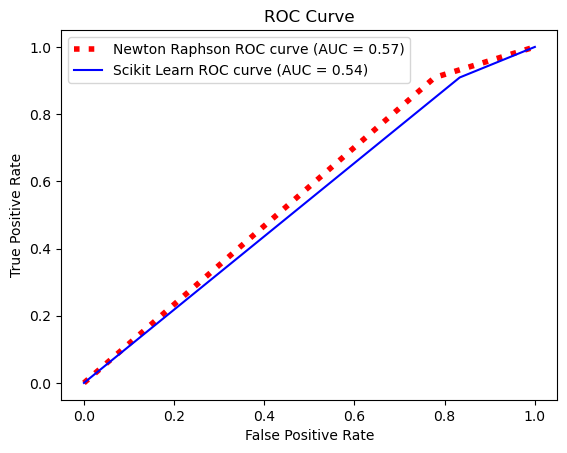

In [13]:
# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, NP_preds)
fpr2, tpr2, _ = roc_curve(y_test, SC_preds)
roc_auc = auc(fpr, tpr)
roc_auc2 = auc(fpr2, tpr2)
plt.plot(fpr, tpr, label=f"Newton Raphson ROC curve (AUC = {roc_auc:.2f})", linestyle="dotted", linewidth=4, color="red")
plt.plot(fpr2, tpr2, label=f"Scikit Learn ROC curve (AUC = {roc_auc2:.2f})", color="blue")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
#plt.savefig("ROCthreshold0.55.png")
plt.show()

In [16]:
# Gradient of the negative log-posterior
def grad_neg_log_posterior(beta, X, y):
    N = X.shape[0]
    z = X @ beta
    g_x = sigmoid(z)
    return X.T @ (g_x - y) + beta   

# Hessian of the negative log-posterior
def hessian_neg_log_posterior(beta, X):
    N = X.shape[0]
    z = X @ beta
    g_x = sigmoid(z)
    W = g_x * (1 - g_x)
    return (X.T*W) @ X  # TODO: Implement the hessian of Negative log-posterior


In [15]:
hessian = hessian_neg_log_posterior
gradient = grad_neg_log_posterior

# Train logistic regression model for Laplace approximation
LA_beta = newton_raphson(X_train, y_train)

# Predictions and evaluation metrics for Newton Raphson
LA_preds = predict(X_test, LA_beta)
LA_accuracy = accuracy_score(y_test, LA_preds)
LA_precision = precision_score(y_test, LA_preds)
LA_recall = recall_score(y_test, LA_preds)
LA_f1 = f1_score(y_test, LA_preds)

# Print metrics
print(f"Laplace approximation Accuracy: {LA_accuracy:.2f}")
print(f"Laplace approximation Precision: {LA_precision:.2f}")
print(f"Laplace approximation Recall: {LA_recall:.2f}")
print(f"Laplace approximation F1 Score: {LA_f1:.2f}")

Laplace approximation Accuracy: 0.71
Laplace approximation Precision: 0.74
Laplace approximation Recall: 0.91
Laplace approximation F1 Score: 0.82
